<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/16_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning

Two ways to do the same:
1. Freeze the initial model tarined and add the fine-tuning layers at end of model
2. Pick the model'e pre-trained weights and further fine-tune whole model by initializing from pre-trained weights and move beyond

Utility:
1. Use existing model trained on huge datasets to solve new problems
2. Fine-tune existing model to your unique data
3. Deploy experimental models with limited computational and data resources

When to use:
1. Your problem is similar to the problem that someone else has solved (and published their model)
2. Model is trained on a lot more data than what you have.
3. The model is deep (shallow models are less likely to transfer less)

How to transfer learn:
1. Do you have insufficient complex data?
2. Does a well trained model exist?
3. Which layers to freeze? - The closer the data to the source model, the more layers you can freeze.
4. Fine-tune the target model as much as possible.
5. Inspect the model and results carefully, and never assume TL is always successful.

### MNIST -> FMNIST : Full model fine-tuning

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torchvision
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
### MNIST data

# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels, normalize, reshape
labelsT   = torch.tensor( data[:,0] ).long()
data      = data[:,1:]
dataNorm  = data / np.max(data)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float()

# split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataNormT, labelsT, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [3]:
### FMNIST data

# transformations
transform = T.Compose([ T.ToTensor(), T.Normalize(.5,.5) ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(testset, batch_size=len(testset))

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.11MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 149kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.9MB/s]


In [4]:

# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)

      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (NOTE: Using SGD here to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.005)

  return net,lossfun,optimizer

In [5]:

# a function that trains the model

# input the network and the number of epochs to train
def function2trainTheModel(net,train_loader,test_loader,numepochs=10):

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compute test accuracy
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [6]:
# create a new model
numberNet,lossfun,optimizer = createTheMNISTNet()

# train it on numbers data
trainAcc,testAcc,losses,numberNet = function2trainTheModel(numberNet,numbers_train_loader,numbers_test_loader,5)

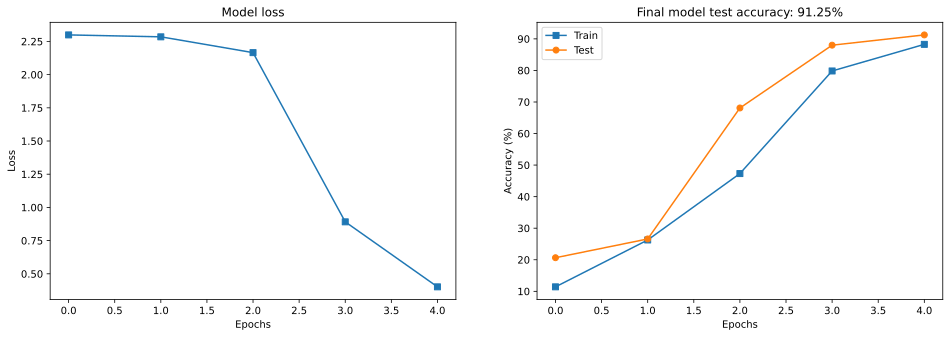

In [7]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

Test the model on FMNIST data

In [8]:
# test the model with fashion data

# extract X,y from FASHION test dataloader
X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 9.84%


Fine-tune the model using one batch

In [9]:
## NOTE about this cell: I've added print() statements in here to show that the copying works.
## The first print function will show a non-zeros matrix because the weights of the two models
## differ. The second print function shows the zeros matrix because the two models have identical
## weights. See Q&A for this lecture.

# create the target model
fashionNet,lossfun,optimizer = createTheMNISTNet()
print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0] )

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(fashionNet.named_parameters(),numberNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0] )

tensor([[[-0.2193, -0.2466,  0.0803, -0.0200,  0.0297],
         [-0.1340,  0.0461, -0.3119, -0.0808, -0.1394],
         [ 0.2184, -0.2558,  0.2244,  0.2204, -0.0440],
         [ 0.1658, -0.2630,  0.0188, -0.0363, -0.1761],
         [ 0.0755, -0.2122, -0.0983,  0.1995, -0.0599]]],
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SubBackward0>)


In [10]:
# Note: you'd think that the following should work, but deepcopy() doesn't copy many features of classes.
# Try it and see what happens!
#DUDL_transfer_MNISTtoFMNIST = copy.deepcopy( numberNet )


# now re-train the network on the numbers data

trainAcc,testAcc,losses,fashionNet = function2trainTheModel(
                                         fashionNet,fashion_train_loader,fashion_test_loader,1)


print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

numberNet TRAIN accuracy: 68.45%
numberNet TEST accuracy: 76.85%


### Letters to Numbers: Freeze the model and finetune final layers

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
from sklearn.model_selection import train_test_split


# NEW! for importing data
import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
# download the datasets
letterdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)
numberdata = torchvision.datasets.EMNIST(root='emnist',split='digits',download=True)

100%|██████████| 562M/562M [00:05<00:00, 94.0MB/s]


In [3]:
# transformations on the letter data

# remove N/A class
letterCategories = letterdata.classes[1:]
labels = copy.deepcopy(letterdata.targets)-1

# transform to 4D tensor for conv layers (and transform from int8 to float)
letterImages = letterdata.data.view([letterdata.data.shape[0],1,28,28]).float()
letterImages /= torch.max(letterImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(letterImages, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
letter_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
letter_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
### transformations on numbers data

# transform to 4D tensor for conv layers (and transform from int8 to float)
numberImages = numberdata.data.view([numberdata.data.shape[0],1,28,28]).float()
numberImages /= torch.max(numberImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(numberImages, numberdata.targets, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
number_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
number_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

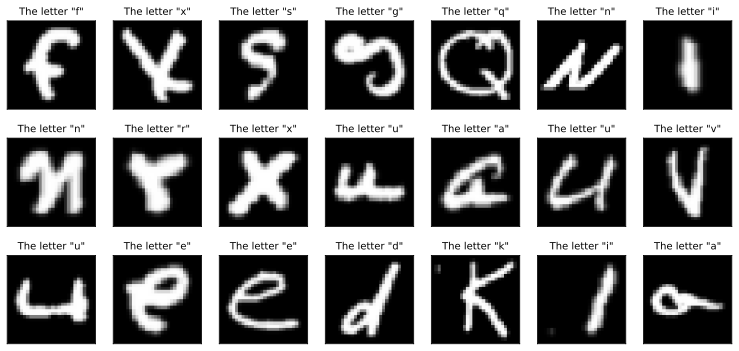

In [5]:
# visualize some letters
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of letter data
X,y = next(iter(letter_train_loader))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  letter = letterCategories[y[i]]

  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The letter "%s"'%letter,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

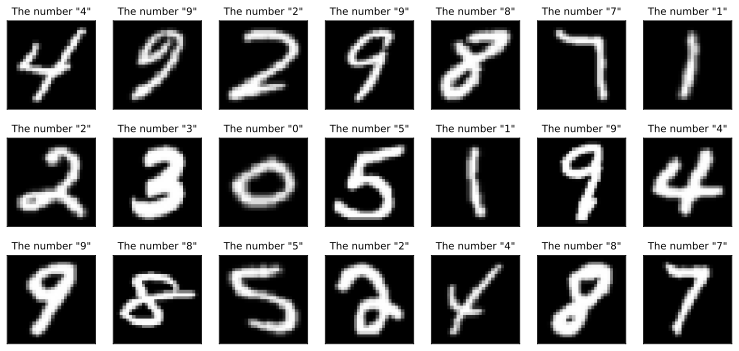

In [6]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(number_train_loader))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  number = y[i].item()

  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The number "%s"'%number,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [7]:

# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [8]:

# a function that trains the model

def function2trainTheModel(net,optimizer,train_loader,test_loader,numepochs=10):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

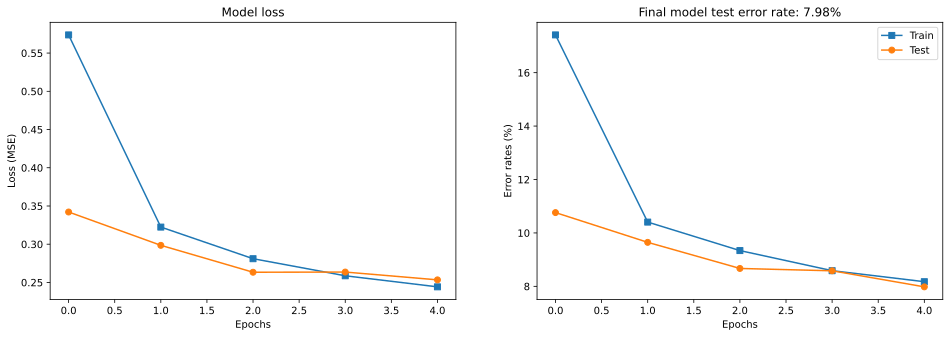

In [9]:
# create a new model
letterNet,lossfun,optimizer = makeTheNet()

trainLoss,testLoss,trainErr,testErr,letterNet = function2trainTheModel(
                                                letterNet,optimizer,letter_train_loader,letter_test_loader,5)


fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [10]:
X,y = next(iter(number_test_loader))
X = X.to(device)
y = y.to(device)

letterNet.eval()
yHat = letterNet(X)

# the test
numberAcc = 100*torch.mean((torch.argmax(yHat,axis=1)!=y).float())

print(f'numberNet error rate on NUMBER data: {numberAcc:.2f}%')

numberNet error rate on NUMBER data: 95.65%


Fine-tune the model with one training batch

In [11]:
# create the target model
numberNet,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet.named_parameters(),letterNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

In [12]:
# check out the network
print(numberNet)
print(' ')

# and the final layer
print(numberNet.fc2)

# replace the final layer to have 10 outputs instead of 26
numberNet.fc2 = nn.Linear(50,10)

# and check it again
print(' ')
print(numberNet)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)
 
Linear(in_features=50, out_features=26, bias=True)
 
emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [13]:
# now re-train the network on the numbers data

trainLoss,testLoss,trainErr,testErr,numberNet = function2trainTheModel(
                                                   numberNet,optimizer,number_train_loader,number_test_loader,1)


print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

numberNet TRAIN error rate: 3.01%
numberNet TEST error rate: 1.20%


Try again, only train output layer

In [14]:
# create the target model
numberNet2,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet2.named_parameters(),letterNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

# adjust number of output units
numberNet2.fc2 = nn.Linear(50,10)

# freeze convolution and batch-norm layers
for p in numberNet2.named_parameters():
  if ('conv' in p[0]) or ('bnorm' in p[0]):
    p[1].requires_grad = False

In [15]:
# now re-train the network on the numbers data

trainLoss,testLoss,trainErr,testErr,numberNet2 = function2trainTheModel(
                                                   numberNet2,optimizer,number_train_loader,number_test_loader,1)


print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

numberNet TRAIN error rate: 2.87%
numberNet TEST error rate: 1.34%


In [17]:
from torchsummary import summary
summary(numberNet2,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
       BatchNorm2d-2            [-1, 6, 14, 14]              12
            Conv2d-3            [-1, 6, 14, 14]             330
       BatchNorm2d-4              [-1, 6, 7, 7]              12
            Linear-5                   [-1, 50]          14,750
            Linear-6                   [-1, 10]             510
Total params: 15,674
Trainable params: 15,260
Non-trainable params: 414
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.06
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


### Resnet-18 Transfer Learning

In [18]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [19]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
### Note: resnet is trained for images in a specific range (NOT [-1,1]).
#         That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

100%|██████████| 2.64G/2.64G [02:32<00:00, 17.3MB/s]


In [21]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(np.uint8(0), np.uint8(255))

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [22]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x96x96
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


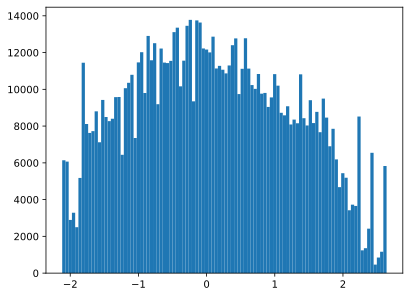

In [23]:
# histogram of the data
plt.hist(X.data.numpy().flatten(),100);

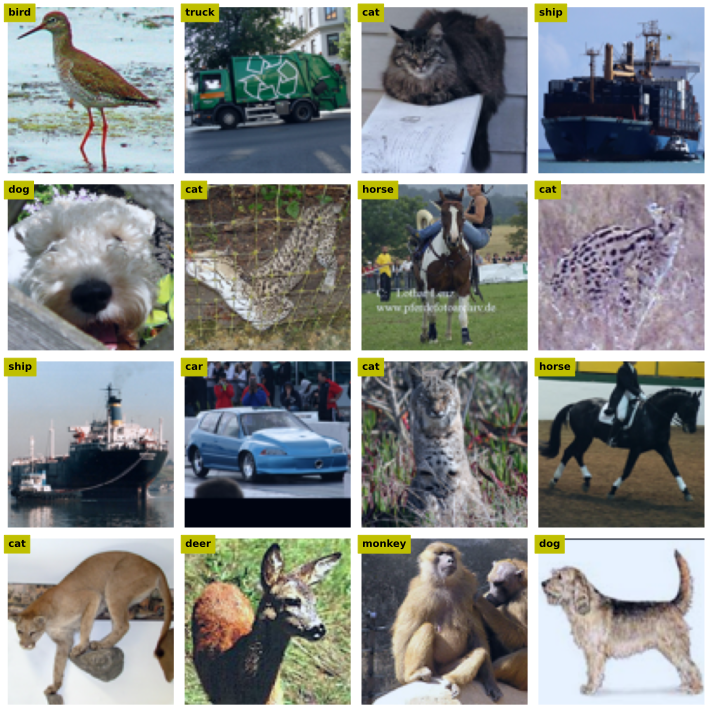

In [24]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [25]:
# The following line was recorded in the video, but is now depreciated. See also Q&A.
# resnet = torchvision.models.resnet18(pretrained=True)

# You can use the following instead.
weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet = torchvision.models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [26]:
# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
from torchsummary import summary
summary(resnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [28]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False

    # python note: the above operation can be implemented in-line:
    #p.requires_grad_(False)

In [29]:
# change the final layer
resnet.fc = nn.Linear(512,10)

# push the model to the GPU (if using)
resnet.to(device);

In [33]:

numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

Finished epoch 1/10. Test accuracy = 12.46%
Finished epoch 2/10. Test accuracy = 12.17%
Finished epoch 3/10. Test accuracy = 12.16%
Finished epoch 4/10. Test accuracy = 12.62%
Finished epoch 5/10. Test accuracy = 11.91%
Finished epoch 6/10. Test accuracy = 12.37%
Finished epoch 7/10. Test accuracy = 11.91%
Finished epoch 8/10. Test accuracy = 12.29%
Finished epoch 9/10. Test accuracy = 12.32%
Finished epoch 10/10. Test accuracy = 11.77%


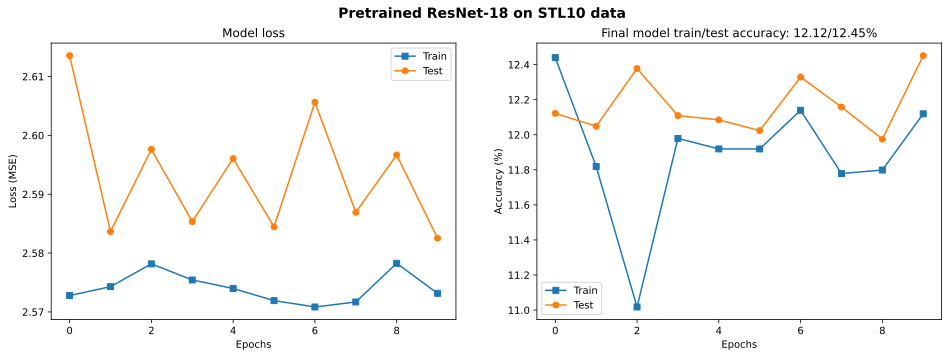

In [31]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

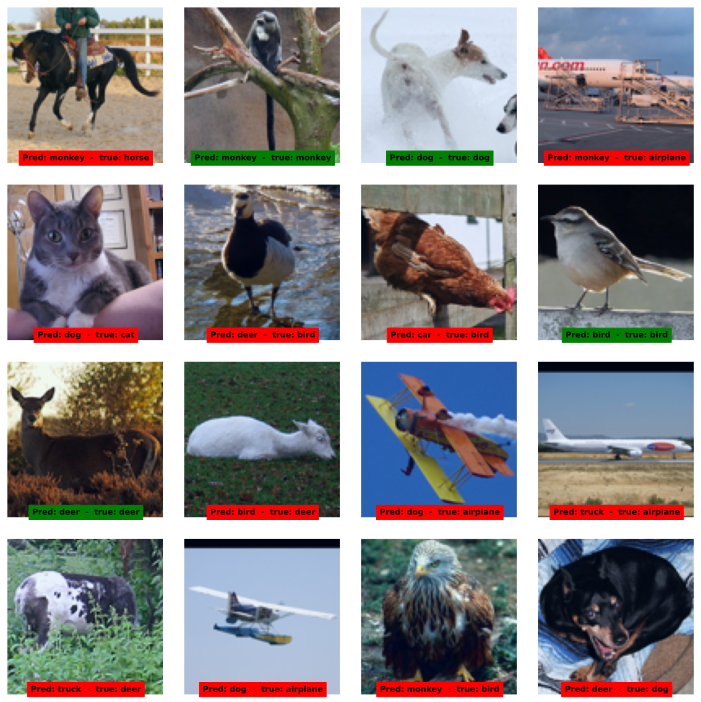

In [32]:

# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # show the image
  ax.imshow(pic)


  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

### VGG-16 Transfer Learning

In [34]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

In [36]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(np.uint8(0), np.uint8(255))

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [37]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x96x96
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data),torch.mean(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400), tensor(-0.1052))


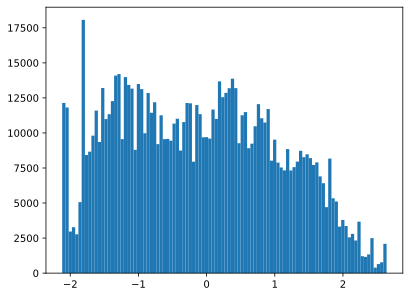

In [38]:
# histogram of the data
plt.hist(X.data.numpy().flatten(),100);

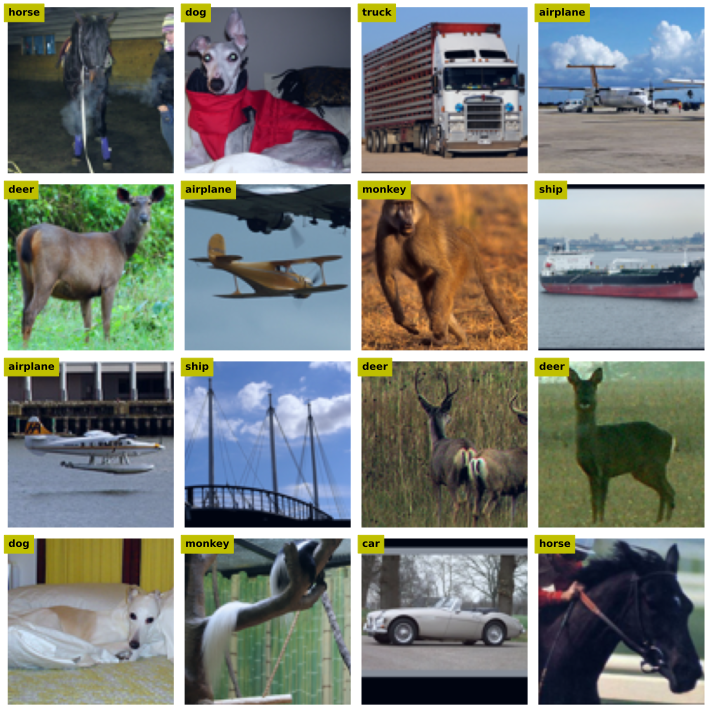

In [39]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [40]:
vggnet = torchvision.models.vgg16(pretrained=True)
vggnet

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 75.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
# Freeze all layers (final layer changed later)
for p in vggnet.parameters():
    p.requires_grad = False


# change the final layer (this time soft-coded!)
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features,10)


# push the model to the GPU (if using)
vggnet.to(device);

In [42]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vggnet.parameters(),lr=0.001,momentum=.9)

numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  vggnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = vggnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  vggnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = vggnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

Finished epoch 1/10. Test accuracy = 90.25%
Finished epoch 2/10. Test accuracy = 91.03%
Finished epoch 3/10. Test accuracy = 91.09%
Finished epoch 4/10. Test accuracy = 91.43%
Finished epoch 5/10. Test accuracy = 91.25%
Finished epoch 6/10. Test accuracy = 91.36%
Finished epoch 7/10. Test accuracy = 91.75%
Finished epoch 8/10. Test accuracy = 91.48%
Finished epoch 9/10. Test accuracy = 91.69%
Finished epoch 10/10. Test accuracy = 91.06%


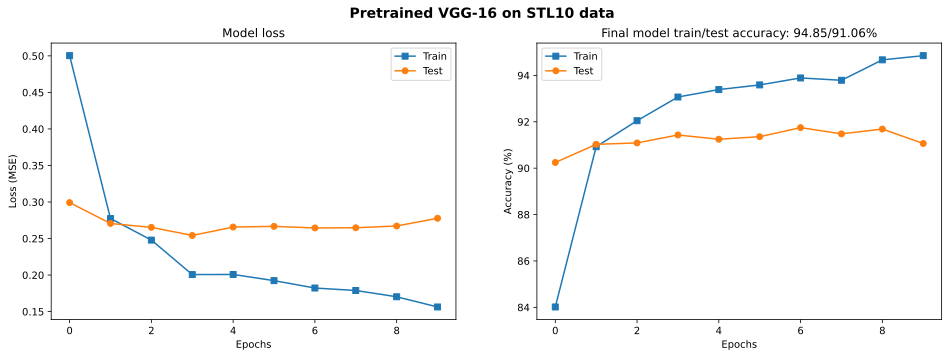

In [43]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

Pretraining with Autoencoders Models

In [45]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [46]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


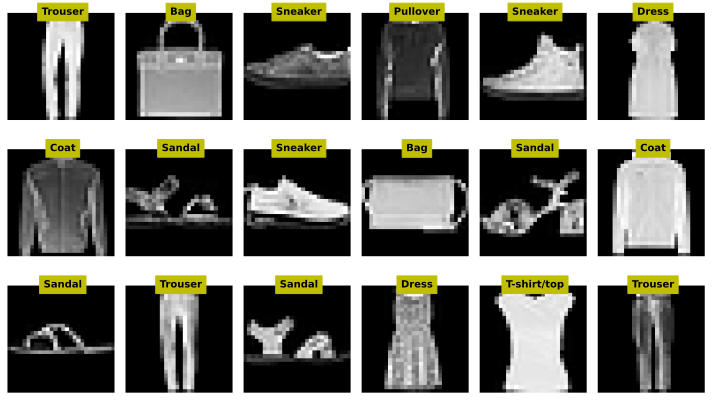

In [47]:
# inspect a few random images
X,y = next(iter(test_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [48]:

# create a class for the model
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7


      ### -------------- decoder layers -------------- ###
      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7




    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # first decoder layer
      x = F.leaky_relu(self.decconv1(x))
      if self.print: print(f'First decoder layer: {list(x.shape)}')

      # second decoder layer
      x = F.leaky_relu(self.decconv2(x))
      if self.print: print(f'Second decoder layer: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [49]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheAENet(True)

X,y = next(iter(train_loader))
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
First decoder layer: [32, 16, 14, 14]
Second decoder layer: [32, 1, 28, 28]

Output size:
torch.Size([32, 1, 28, 28])
 
Loss:
tensor(0.6953, grad_fn=<MseLossBackward0>)


In [50]:

# a function that trains the model

def function2trainTheAEModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheAENet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,X)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,devLoss,net

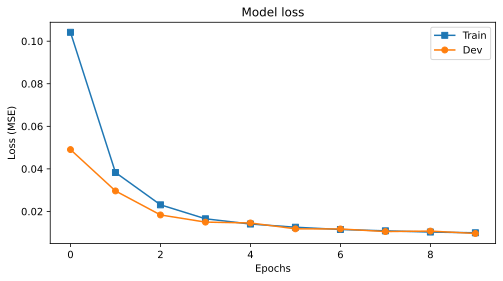

In [51]:
# ~3 minutes with 10 epochs on GPU
trainLoss,devLoss,aenet = function2trainTheAEModel()


fig = plt.figure(figsize=(8,4))

plt.plot(trainLoss,'s-',label='Train')
plt.plot(devLoss,'o-',label='Dev')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')
plt.legend()

plt.show()

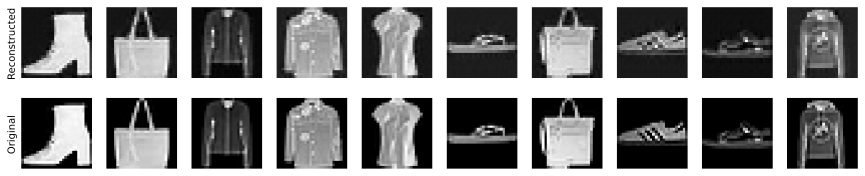

In [52]:

## show some random examples

# get some data
X,y = next(iter(dev_loader))

# forward pass and loss
aenet.cpu()
aenet.eval() # switch to test mode
yHat = aenet(X)

fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  pic = yHat[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].axis('off')

  pic = X[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic,cmap='gray')
  axs[1,i].axis('off')

  if i==0:
    axs[0,0].text(-6,14,'Reconstructed',rotation=90,va='center')
    axs[1,0].text(-6,14,'Original',rotation=90,va='center')


plt.show()

Now create a classification model

In [53]:

# create a class for the model
def makeTheClassNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7


      ### ------------- linear layers ------------- ###
      self.fc1  = nn.Linear(7*7*32,50)
      self.fc2  = nn.Linear(50,10)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # reshape to linear
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      if self.print: print(f'First linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc2(x))
      if self.print: print(f'Second linear layer: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [54]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheClassNet(True)

X,y = next(iter(train_loader))
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
Post-convolution vectorized: [32, 1568]
First linear layer: [32, 50]
Second linear layer: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.2979, grad_fn=<NllLossBackward0>)


In [55]:

# a function that trains the model

def function2trainTheClassModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()
  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

In [56]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet,lossfun,optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive,devLossNaive,trainAccNaive,devAccNaive,naivenet = function2trainTheClassModel(naivenet,lossfun,optimizer)


## evaluate on the test set
naivenet.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = naivenet(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLossNaive = loss.item()
testAccNaive  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

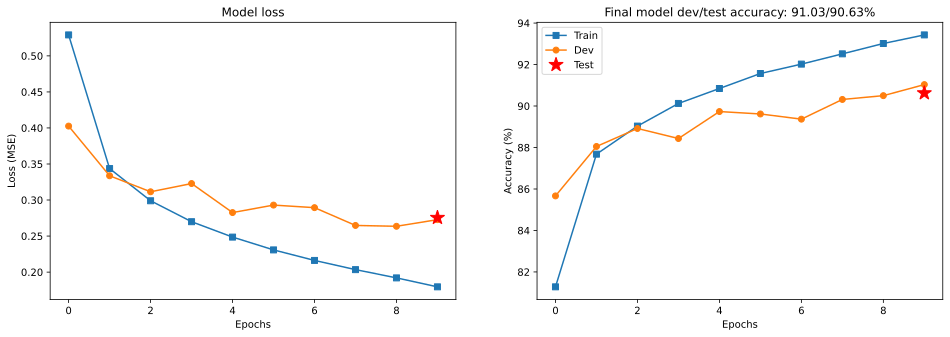

In [57]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(devLossNaive,'o-',label='Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(devAccNaive,'o-',label='Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAccNaive[-1]:.2f}/{testAccNaive:.2f}%')
ax[1].legend()

plt.show()

Build a new model but replace the convolution layers with with AE layer

In [58]:
pretrainNet,lossfun,optimizer = makeTheClassNet()

#### Note about the code below: Both networks have the same number of layers overall; in other applications
#    you may need to modify the code to find the matching layers.

# then replace the conv weights in TARGET model from encoder weights in SOURCE model
for target,source in zip(pretrainNet.named_parameters(),aenet.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])
  if 'enc' in target[0]:
    target[1].data = copy.deepcopy( source[1].data )

PRETRAIN: encconv1.weight  AENET: encconv1.weight
PRETRAIN: encconv1.bias  AENET: encconv1.bias
PRETRAIN: encconv2.weight  AENET: encconv2.weight
PRETRAIN: encconv2.bias  AENET: encconv2.bias
PRETRAIN: fc1.weight  AENET: decconv1.weight
PRETRAIN: fc1.bias  AENET: decconv1.bias
PRETRAIN: fc2.weight  AENET: decconv2.weight
PRETRAIN: fc2.bias  AENET: decconv2.bias


In [59]:
# train the pretrained model

# training
trainLossPre,devLossPre,trainAccPre,devAccPre,pretrainNet = function2trainTheClassModel(pretrainNet,lossfun,optimizer)


## evaluate on the test set
pretrainNet.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = pretrainNet(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLossPre = loss.item()
testAccPre  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

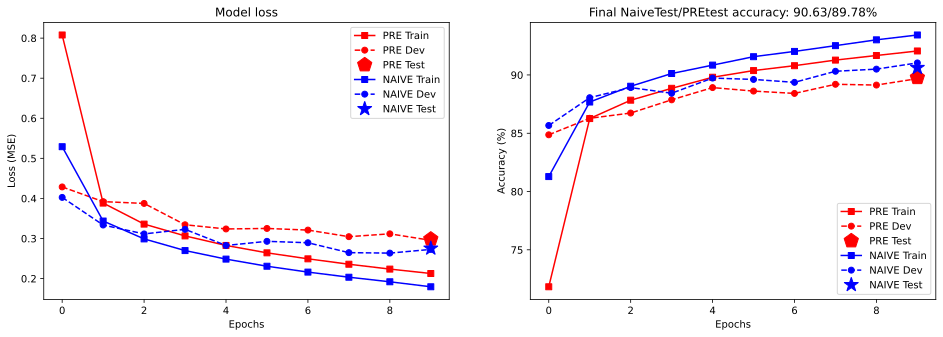

In [60]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(devLossPre,'ro--',label='PRE Dev')
ax[0].plot(len(devLossPre)-1,testLossPre,'rp',markersize=15,label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(devLossNaive,'bo--',label='NAIVE Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'b*',markersize=15,label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(devAccPre,'ro--',label='PRE Dev')
ax[1].plot(len(devAccPre)-1,testAccPre,'rp',markersize=15,label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(devAccNaive,'bo--',label='NAIVE Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'b*',markersize=15,label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive:.2f}/{testAccPre:.2f}%')
ax[1].legend()

plt.show()

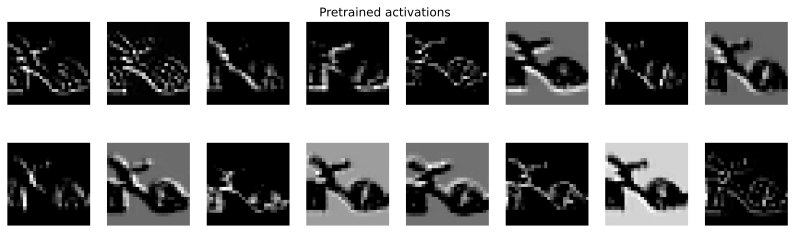

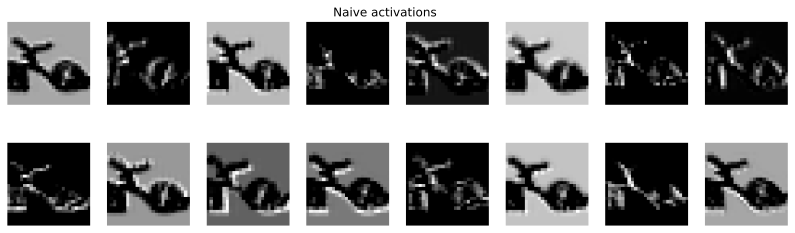

In [61]:
#### Perhaps they differ by feature map activation?

# grab one image
x = X[10,:,:,:].view(1,1,28,28)

# compute the activations of the first layer (excluding the bias b/c this is simply a constant)
layer1ActPre = F.relu( F.conv2d(x,pretrainNet.encconv1.weight) )
layer1ActNai = F.relu( F.conv2d(x,naivenet.encconv1.weight) )



## show the feature map activations for the pretrained model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActPre[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Pretrained activations',y=.9)
plt.show()



## show the feature map activations for the naive model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActNai[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Naive activations',y=.9)
plt.show()

### CIFAR10 with autoencoder pretrained model

In [62]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [63]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize        = 32
train_loaderFull = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loaderFull  = DataLoader(testset, batch_size=256)

100%|██████████| 170M/170M [00:04<00:00, 40.7MB/s]


In [64]:
# Create smaller DataLoaders with only 2k images (used later)

trainsetSmall = torch.utils.data.Subset(trainset,range(2000))
train_loaderSmall = DataLoader(trainsetSmall,batch_size=batchsize,shuffle=True)

testsetSmall = torch.utils.data.Subset(testset,range(2000))
test_loaderSmall = DataLoader(testsetSmall,batch_size=batchsize,shuffle=True)

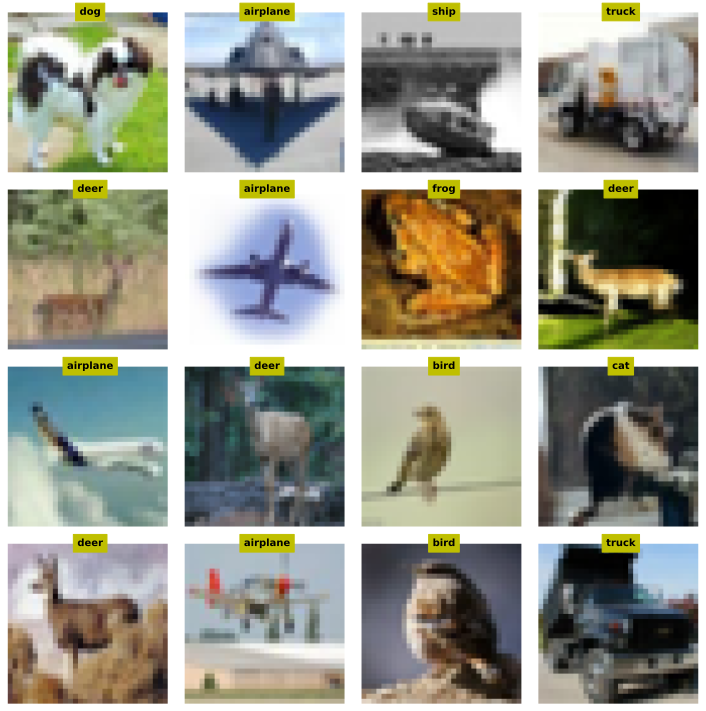

In [65]:
# inspect a few random images

X,y = next(iter(train_loaderSmall))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [66]:

# create a class for the model
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoding layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (32+2*1-4)/2 + 1 = 16

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (16+2*1-4)/2 + 1 = 8

      # third convolution layer
      self.encconv3  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (8+2*1-4)/2 + 1 = 4


      ### -------------- decoding layers -------------- ###

      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      # third convolution layer (output)
      self.decconv3  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu( self.encconv1(x) )
      if self.print: print(f'First encoder block: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu( self.encconv2(x) )
      if self.print: print(f'Second encoder block: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu( self.encconv3(x) )
      if self.print: print(f'Third encoder block: {list(x.shape)}')




      # first decoder block
      x = F.leaky_relu( self.decconv1(x) )
      if self.print: print(f'First decoder block: {list(x.shape)}')

      # second decoder block
      x = F.leaky_relu( self.decconv2(x) )
      if self.print: print(f'Second decoder block: {list(x.shape)}')

      # third decoder block (output)
      x = F.leaky_relu( self.decconv3(x) )
      if self.print: print(f'Decoder output: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [67]:
# test the model with one batch
aenet,lossfun,optimizer = makeTheAENet(True)

X,y = next(iter(train_loaderSmall))
yHat = aenet(X)

# now compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
 
Loss:
tensor(0.2137, grad_fn=<MseLossBackward0>)


In [68]:

# a function that trains the model

def function2trainTheAEModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 15

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []

    for X,y in train_loaderFull:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []

    for X,y in test_loaderFull:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainLoss,testLoss,net

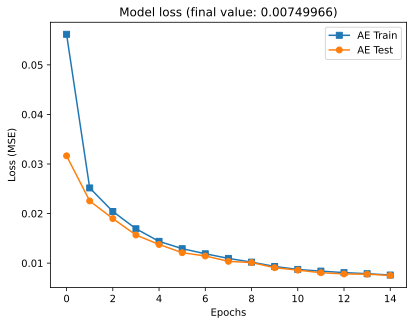

In [69]:
# ~4 minutes with 15 epochs on GPU

# create a new model (comment out to re-train)
netAE,lossfun,optimizer = makeTheAENet()

trainLossAE,testLossAE,netAE = function2trainTheAEModel(netAE,lossfun,optimizer)


plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLossAE[-1])
plt.legend()

plt.show()

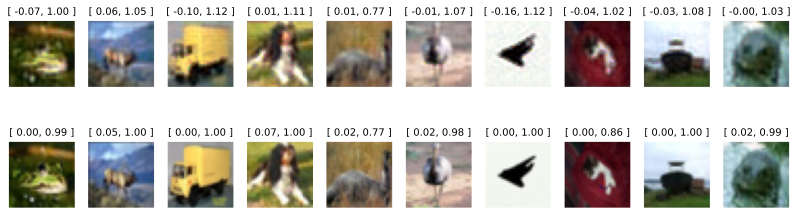

In [70]:

## show some random examples

# get some data
X,y = next(iter(test_loaderSmall))

# forward pass and loss
netAE.cpu()
netAE.eval() # switch to test mode
yHat = netAE(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')


plt.show()

Now create a new model that does classification

In [71]:

# create a class for the model
def makeTheClassNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoding layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (28+2*1-4)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (14+2*1-4)/2 + 1 = 7

      # third convolution layer
      self.encconv3  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (7+2*1-4)/2 + 1 = 4



      ### ------------- linear layers ------------- ###
      self.fc1  = nn.Linear(4*4*64,128)
      self.fc2  = nn.Linear(128,64)
      self.fc3  = nn.Linear(64,10)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # third encoder layer
      x = F.leaky_relu(self.encconv3(x))
      if self.print: print(f'Third encoder layer: {list(x.shape)}')

      # reshape to linear
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      if self.print: print(f'First linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc2(x))
      if self.print: print(f'Second linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc3(x))
      if self.print: print(f'Output linear layer: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [72]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheClassNet(True)

X,y = next(iter(train_loaderSmall))
yHat = tmpnet(X)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder layer: [32, 16, 16, 16]
Second encoder layer: [32, 32, 8, 8]
Third encoder layer: [32, 64, 4, 4]
Post-convolution vectorized: [32, 1024]
First linear layer: [32, 128]
Second linear layer: [32, 64]
Output linear layer: [32, 10]
 
Loss:
tensor(2.2918, grad_fn=<NllLossBackward0>)


In [73]:

# a function that trains the model

def function2trainTheClassModel(net,lossfun,optimizer,train_loader,test_loader):

  # number of epochs
  numepochs = 10

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)



    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []
    batchAcc  = []

    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi]  = 100*np.mean(batchAcc)

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [74]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet,lossfun,optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive,testLossNaive,trainAccNaive,testAccNaive,naivenet = function2trainTheClassModel(
                                                                      naivenet,lossfun,optimizer,train_loaderSmall,test_loaderSmall)

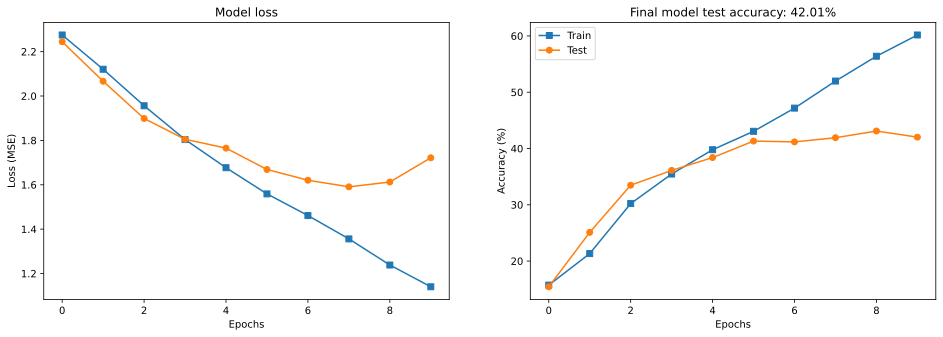

In [75]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(testLossNaive,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(testAccNaive,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAccNaive[-1]:.2f}%')
ax[1].legend()

plt.show()

Build a new model but replace the convolution layers with with AE layer

In [80]:
# create a new network (weights replaced below)
pretrainNet,lossfun,optimizer = makeTheClassNet()


#### Note about the code below: Both networks have the same number of layers overall; in other applications
#    you may need to modify the code to find the matching layers.

# Note 2: The code in the video had a bug where I used the wrong model variable name: we want 'netAE' not 'aenet'.
#         Conclusions in the video are still valid, and the code below is correct.

# Replace the conv weights in TARGET model from encoder weights in SOURCE model
for target,source in zip(pretrainNet.named_parameters(),netAE.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])

  if 'enc' in target[0]:

    # copy over the parameters...
    target[1].data = copy.deepcopy( source[1].data )

    # ...and then freeze that layer
    target[1].requires_grad = False

PRETRAIN: encconv1.weight  AENET: encconv1.weight
PRETRAIN: encconv1.bias  AENET: encconv1.bias
PRETRAIN: encconv2.weight  AENET: encconv2.weight
PRETRAIN: encconv2.bias  AENET: encconv2.bias
PRETRAIN: encconv3.weight  AENET: encconv3.weight
PRETRAIN: encconv3.bias  AENET: encconv3.bias
PRETRAIN: fc1.weight  AENET: decconv1.weight
PRETRAIN: fc1.bias  AENET: decconv1.bias
PRETRAIN: fc2.weight  AENET: decconv2.weight
PRETRAIN: fc2.bias  AENET: decconv2.bias
PRETRAIN: fc3.weight  AENET: decconv3.weight
PRETRAIN: fc3.bias  AENET: decconv3.bias


In [81]:
# double-check that they match
pretrainNet.cpu().encconv1.weight[10] - netAE.encconv1.weight[10]

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<SubBackward0>)

In [82]:
# train the pretrained model

# training
trainLossPre,testLossPre,trainAccPre,testAccPre,pretrainNet = function2trainTheClassModel(
                                                                pretrainNet,lossfun,optimizer,train_loaderSmall,test_loaderSmall)

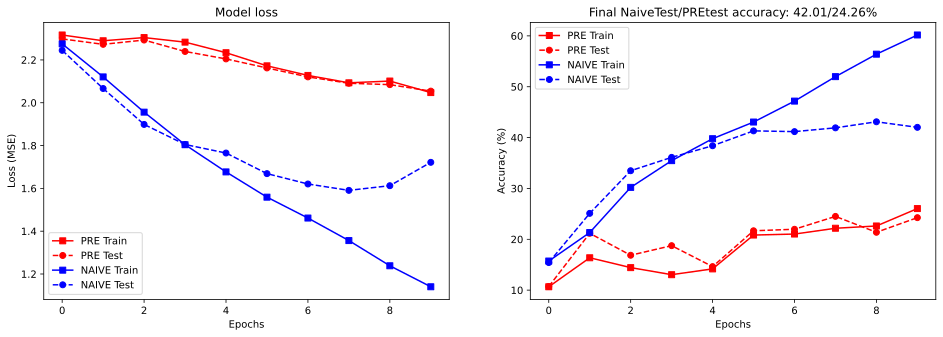

In [83]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(testLossPre,'ro--',label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(testLossNaive,'bo--',label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(testAccPre,'ro--',label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(testAccNaive,'bo--',label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive[-1]:.2f}/{testAccPre[-1]:.2f}%')
ax[1].legend()

plt.show()